# What is this notebook about?
In this notebook, I'll try to explore how [scikit learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [xgboost](https://github.com/dmlc/xgboost) extract feature importances for their tree-based models. I'll therefore explain different ways to calculate those feature importances, based on a small toy data set.

In [28]:
# load libraries
%pylab inline
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

Populating the interactive namespace from numpy and matplotlib


# The toy data set
Let's create our toy data set. It contains artificial data about whether or not we are able to play golf on a golf court based on some weather conditions (inspiration from [this awesome presentation](http://www.ke.tu-darmstadt.de/lehre/archiv/ws0809/mldm/dt.pdf)):

In [98]:
data = pd.read_csv('golf.csv')
data.assign(**{'play_golf?': lambda df: df['play_golf?'].apply(lambda x: 'yes' if x == 1 else 'no')})

,hot?,rain?,humid?,windy?,play_golf?
0,1,0,1,0,no
1,1,0,1,1,no
2,1,0,1,0,yes
3,0,1,0,0,yes
4,0,0,0,1,yes
5,0,0,1,0,no
6,0,0,0,0,yes
7,0,1,0,0,yes
8,0,0,0,1,yes
9,0,0,1,1,yes


Let's set the target variable that we want to predict, and the feature variables that we want to use to predict the target:

In [30]:
target = ['play_golf?']
features = ['hot?', 'rain?', 'humid?', 'windy?']

X = data[features]
y = data[target]

# Feature importance: scikit learn vs. xgboost
Let's train both scikit learn's and xgb's algorithms for gradient boosted trees on the toy data set, and compare what sort of feature importances they are going to spit out:

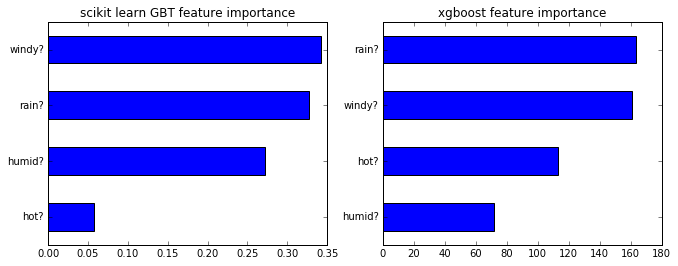

In [59]:
# train scikit learn model
skl_clf = GradientBoostingClassifier(random_state=2)
skl_clf.fit(X, y.values.ravel())

# plot feature importances
feature_importance = skl_clf.feature_importances_
figure(figsize(11,4))
subplot(121)
pd.DataFrame([feature_importance], columns=features).T.sort_values(0).plot(kind='barh', legend=False, ax=gca())
title('scikit learn GBT feature importance');

# train xgboost model
xgb_clf = XGBClassifier(min_child_weight=0, seed=2)
xgb_clf.fit(X, y.values.ravel())

# plot feature importances
subplot(122)
f_score = xgb_clf.booster().get_fscore()
pd.DataFrame([f_score]).T.sort_values(0).plot(kind='barh', legend=False, ax=gca())
title('xgboost feature importance');

The feature importances that the two models spit out are kind of similar, but still quite different! Of course, this is partly due to the fact that the algorithms are slightly different. But another reason might be that both models actually calculate the importances in a different way. Let's try to find this out!

### What does feature importance mean in scikit learn and xgboost?
Let's have a look at the docs:

__xgboost__
from http://xgboost.readthedocs.io/en/latest/python/python_api.html:
```
"get_fscore(fmap='')
Get feature importance of each feature."
```
Not really helpful :) Let's check [stackoverflow](http://stackoverflow.com/questions/34218245/how-is-the-feature-score-in-the-xgboost-package-calculated) instead : 

```"This [i.e. the f-score] is a metric that simply sums up how many times each feature is split on."```

That's a much better definition!

__scikit learn__ from http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html:
```
feature_importances_ : array of shape = [n_features]
The feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini
importance.
```
That definition is OK, although not really specific (Furthermore, I do not think that regression models will use Gini importance...).

# Measures of feature importances
Let's see what the above two definitions of feature importance mean in practice on the basis of our toy data set. To keep things simple, let's fit a single decision tree to our data and visualize it:

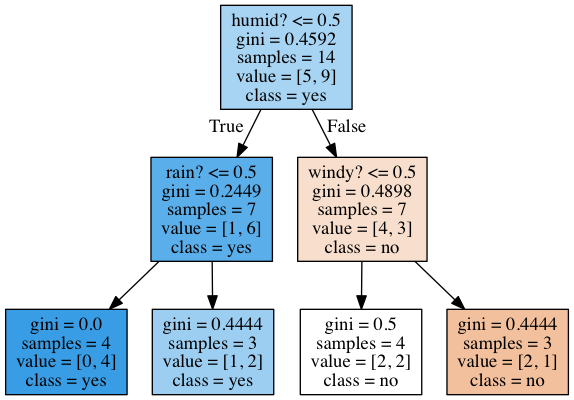

In [105]:
# fit tree
from sklearn import tree
skl_tree = tree.DecisionTreeClassifier(max_depth=2, random_state=1)
skl_tree.fit(X, y)

# visualize tree
from IPython.display import Image  
import pydot
from sklearn.externals.six import StringIO
dot_data = StringIO()  
tree.export_graphviz(skl_tree, out_file=dot_data, feature_names=features, class_names=['no', 'yes'], filled=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Quick explanation for this graph representation of the decision tree:
- Each node represents a split based on a variable (indicated in the top row of each node)
- The second row in a node displays the Gini index of that node (explained below)
- The third row shows how many samples are in this node (e.g. the top node contains all 14 samples of our data set)
- The fourth row shows the class distribution within that node (e.g. 5 samples of class 'no' and 9 samples of class 'yes' for the top node)
- The last row indicates the majority class if that node (e.g. more 'yes' samples than 'no' samples for the top node)

## 1) f-score (xgboost)
This is what xgboost is using for calculating feature importance. Simply counts the number of times a feature was split on. In the tree above, three of the four features occur once in the tree, i.e. the f-score is one for each of those features:

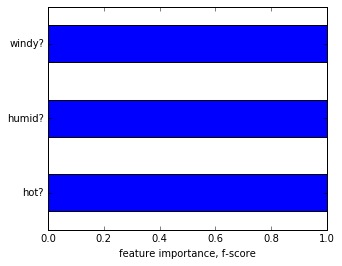

In [110]:
xgb_single_tree = XGBClassifier(min_child_weight=0, seed=2, n_estimators=1)
xgb_single_tree.fit(X,y.values.ravel())
figure(figsize(5,4));
pd.DataFrame([xgb_single_tree.booster().get_fscore()]).T.sort_values(0).plot(kind='barh', legend=False);
xlabel('feature importance, f-score');

Advantage of the f-score measure: It's easy to calculate and easy to understand. Problem: Features that reduce error most (usually occuring on the topof the tree) don't receive more importance than features occuring on lower nodes. 

## 2) Average Gini gain (aka Gini importance, scikit learn)
The Gini importance, which is used by scikit learn's tree models, is better suited to describe feature importance (yet it is more complex to calculate). To understand how it works, we'll need to define two other metrics first: Gini index and Gini gain.

### 2.1 How pure is a node? Gini index
The Gini index is a measure of the _purity_ of a node. A Gini index of 0 means the node is pure (all samples belong to one class), whereas a Gini index of close to 0.5 (the maximum Gini index) means the node is very impure. In general, we want the bottom nodes of our trees to be pure (reflected by a low Gini index), since that means that the majority of training samples in that node are classified correctly.

Let $p_{yes}$ be the proportion of samples within a node whose outcome is "yes".
For example, for the top node of the tree above, $p_{yes}=\frac{9}{14}$. Likewise, $p_{no}=\frac{5}{14}$

The Gini index is defined as $$Gini =  1- \sum_ip_{i}^2 $$

For our two-class problem, we have
$$Gini = 1- p_{yes}^2 - p_{no}^2 = 1- p_{yes}^2 - (1-p_{yes})^2 $$

For our top node, the Gini index is therefore:

In [8]:
gini_top = 1 - (9/14)**2 - (5/14)**2
"{:.4}".format(gini_top)

'0.4592'

This Gini index is also shown in the top node of the graphical representaion of the tree above.

Since for two-class problems, the Gini index only depends on one variable ($p_{yes}$ in our case), we can plot it:

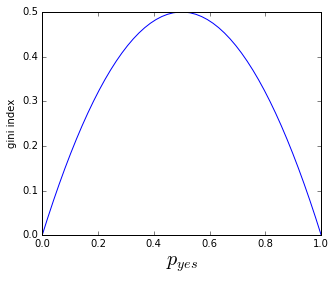

In [111]:
p_yes = linspace(0,1,50)
gini = 1 - p_yes**2 - (1 - p_yes)**2
plot(p_yes, gini); xlabel('$p_{yes}$', size=20); ylabel('gini index');

That means: A pure node (all samples belong to one class, therefore $p_{yes}$ is either 0 or 1) has a Gini index of 0. The maximum Gini index of 0.5 is achieved by maximally impure nodes where the samples are equally distributed among the two classes, i.e. $p_{yes} = 0.5$.

__Remember: Pure nodes mean good classification! We hence want small Gini indexes!__

### 2.2 How much does a particular split improve node purity? Gini gain
- Calculate the average Gini index $\overline{Gini}_{split}$ over all child nodes of the split node (parent node), weighted by their relative sizes $s_c$:
$$ \overline{Gini}_{split} = \sum_{children\,\,c} s_c \cdot Gini_c$$
For the first split in our tree above, we have e.g.
$$ \overline{Gini}_{split\,1}  = \frac{7}{14}\cdot 0.2449 + \frac{7}{14}\cdot 0.4898 \approx 0.3674$$


- Then calculate the Gini gain, i.e. the difference of that average Gini index to the Gini index in the parent node:

$$GiniGain_{split} =  Gini_{parent} - \overline{Gini}_{split} $$

   For example, the first split in our tree above yields the Gini gain

$$GiniGain_{split\,1} = 0.4592 - 0.3674 \approx 0.0918$$

Here are the calculations for the two numbers:

In [11]:
average_gini_index_first_split = (7/14*0.2449 + 7/14*0.4898)
"{:.4}".format(average_gini_index_first_split)

'0.3674'

In [112]:
gini_gain_first_split = gini_top - average_gini_index_first_split
"{:.3}".format(gini_gain_first_split)

'0.0918'

### 2.3 How much does a feature improve node purity? Average Gini gain aka Gini importance
Now we are in a position to calculate the average Gini gain $\overline{GiniGain}$ aka the Gini importane. It describes how much a particular feature decreases overall node purity on average and is hence a good measure to describe the importance of a feature! It can be calculated by summing up the Gini gains for splits $i$ based on that feature, weighted by the proportion of samples reaching the respective splitting node $p_{samples\,in\,node\,i}$.

For example, for our feature ``humidity``, we have:
$$ \overline{GiniGain_{humidity}} = p_{samples\,in\,node\,1} \cdot GiniGain_{split\,1} \approx \frac{14}{14} \cdot0.0918 $$


Note: since there's only one split with the feature ``humidity``, the sum consists only of one term ($i=1$).

Here are the calculations for all Gini gains in the above tree:

In [18]:
av_GiniGain_humidity = 14/14 * (gini_gain_first_split)
av_GiniGain_rain =     7/14  * (0.2449 - ( 4/7*0 +  3/7*0.4444))
av_GiniGain_wind =     7/14  * (0.4898 - ( 4/7*0.5 + 3/7*0.4444))

In [114]:
av_GiniGains = pd.DataFrame([GiniGain_humidity, GiniGain_rain, GiniGain_wind, 0], 
                            index = ['humidity', 'rain', 'wind', 'hot'])
av_GiniGains = av_GiniGains/av_GiniGains.sum()  # normalize 
av_GiniGains.rename(columns={0:'normalized Gini importance'})

,normalized Gini importance
humidity,0.729630
rain,0.216239
wind,0.054131
hot,0.000000


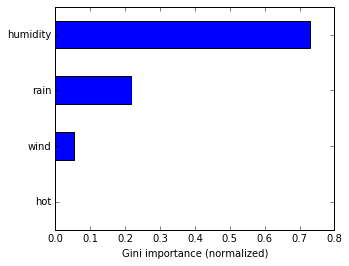

In [116]:
av_GiniGains.sort_values(0).plot(kind='barh', legend=False)
xlabel('Gini importance (normalized)');

This measure seems to be much better than the f-score, as it actually captures how important each feature is in partitioning the data set to its correct classes, not only the number of times it occurs in the tree.
__This is exactly what scikit learn is using:__

In [120]:
sklearn_importance = pd.DataFrame([skl_tree.feature_importances_], columns=features).T.sort_values(0, ascending=False)
sklearn_importance.rename(columns={0:'scikit learn feature importance'})

,scikit learn feature importance
humid?,0.729730
rain?,0.216216
windy?,0.054054
hot?,0.000000


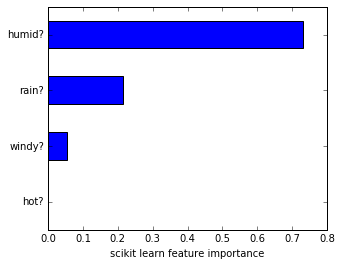

In [119]:
sklearn_importance.sort_values(0).plot(kind='barh', legend=False)
xlabel('scikit learn feature importance');

## 3) Information gain

Information gain is another method to determine feature importance. It can be calculated the same way as Gini gain, using the so called entropy $E$ as a measure of node purity instead of the Gini index:
$$E = - \sum_i p_i \log p_i$$

Information gain is used by the ID3 and C4.5 algorithms, whereas CART uses the Gini index. Both usually lead to very similar results, as entropy and Gini index are very similar:

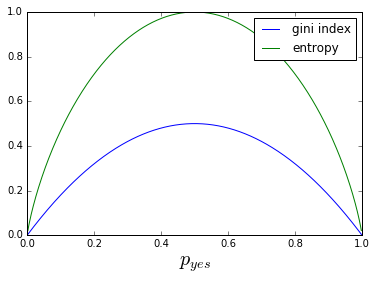

In [36]:
p_yes = linspace(0,1,500)
gini = 1 - p_yes**2 - (1-p_yes)**2
entropy = - (p_yes * log2(p_yes) + (1-p_yes) * log2(1-p_yes))
plot(p_yes, gini, label='gini index'); 
plot(p_yes, entropy, label='entropy'); 
xlabel('$p_{yes}$', size=20);legend();

## 4) What about regression?
Not sure what scikit learn is doing there exactly, but I guess they use mean squared error (MSE) of the samples in a node to determine node purity (http://scikit-learn.org/stable/modules/tree.html).

## 5) How about tree ensembles?
For tree ensemble methods like Random Forest or Gradient Boosted Trees, the feature importances can be calculated by averaging the importances of the single trees of the ensemble.

# So I shouldn't use xgboost to calculate feature importances?
We've seen that scikit learn capures feature importance much better than xgboost's f-score. Is xgboost hence not a good choice to estimate feature importance?

No, feature importance using some sort of gain is actually implemented in the `get_score()` function of the most recent version of xgboost (http://xgboost.readthedocs.io/en/latest/python/python_api.html):
```
get_score(fmap='', importance_type='weight')
Get feature importance of each feature. Importance type can be defined as:

‘weight’ - the number of times a feature is used to split the data across all trees.
 ‘gain’ - the average gain of the feature when it is used in trees 
```

However, it's not yet in the pip repository:

In [266]:
 xgb_clf.booster().get_score()

AttributeError: 'Booster' object has no attribute 'get_score'

# Take home message
1. Feature importance in tree-based methods can be captured well using the average gain in node purity
2. This is what scikit learn implements. For xgboost, you should use the `get_score()` function of the most recent version. Get it e.g. by git cloning [this repository](https://github.com/dmlc/xgboost).